In [1]:
import pandas as pd
import numpy as np

In [2]:
temp_df = pd.read_csv("C:\\Users\\Лев\\Projects\\Diploma\\sbp2.csv", sep=';')
temp_df['time'] = pd.to_datetime(temp_df['time'], dayfirst=True)
temp_df = temp_df.sort_values(by=['time'])
temp = pd.DataFrame(pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h'), columns=['time'])
temp = temp.set_index('time').join(temp_df.set_index('time'), how='left')
temp = temp['T'].ffill()
temp.index = pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h')

In [3]:
temp_train, temp_test = temp.iloc[:-2922], temp.iloc[-2922:]

In [4]:
import warnings 
warnings.filterwarnings('ignore')

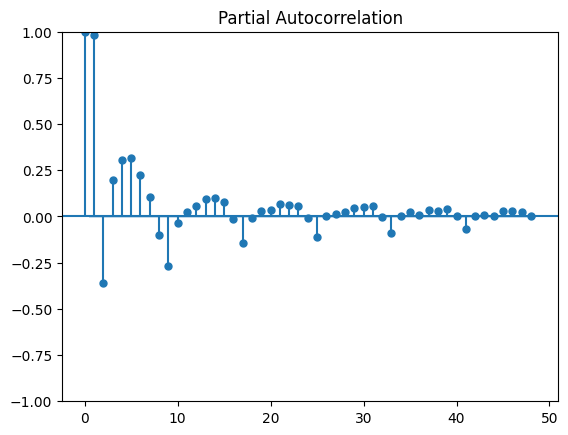

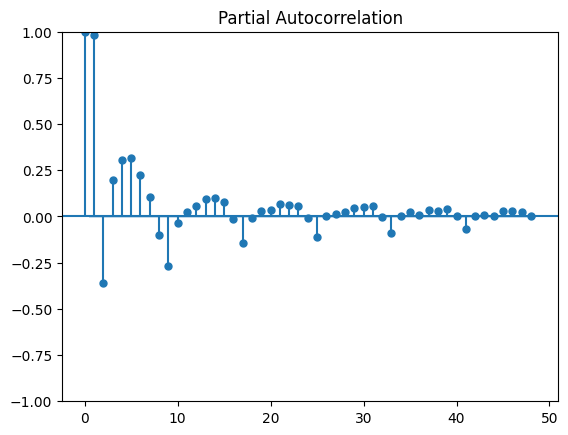

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(temp_train)

In [16]:
from sktime.forecasting.arima import ARIMA

arima_model = ARIMA(order=(15,1,5), seasonal_order=(1,0,1,16))
arima_model.fit(temp_train[-10000:])
np.mean(np.abs(arima_model.predict_residuals()))

c:\Users\Лев\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.878755809628589

In [6]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                30000
Model:             SARIMAX(7, 1, 5)x(1, 0, [1], 8)   Log Likelihood              -49485.405
Date:                             Sun, 12 May 2024   AIC                          99002.810
Time:                                     12:49:05   BIC                          99135.753
Sample:                                 11-11-2012   HQIC                         99045.466
                                      - 02-17-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0018      0.002     -1.023      0.306      -0.005       0.002
ar.L1         -0.2690      0.079     -3.401      0.001      -0.424      -0.114
ar.L2         -0.1593      0.057     -2.796      0.005      -0.271      -0.048
ar.L3         -0.3040      0.060     -5.057      0.000      -0.422      -0.186
ar.L4         -0.4239      0.042    -10.099      0.000      -0.506      -0.342
ar.L5         -0.7291      0.067    -10.855      0.000      -0.861      -0.597
ar.L6          0.0240      0.012      2.075      0.038       0.001       0.047
ar.L7         -0.0791      0.009     -8.501      0.000      -0.097      -0.061
ma.L1          0.3922      0.079      4.968      0.000       0.237       0.547
ma.L2          0.1195      0.049      2.444      0.015       0.024       0.215
ma.L3          0.2176      0.049      4.464      0.000       0.122       0.313
ma.L4          0.3522      0.036      9.687      0.000       0.281       0.423
ma.L5          0.7196      0.058     12.442      0.000       0.606       0.833
ar.S.L8        0.9795      0.002    636.257      0.000       0.977       0.983
ma.S.L8       -0.9176      0.004   -236.753      0.000      -0.925      -0.910
sigma2         1.5898      0.008    202.970      0.000       1.574       1.605
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             24388.85
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

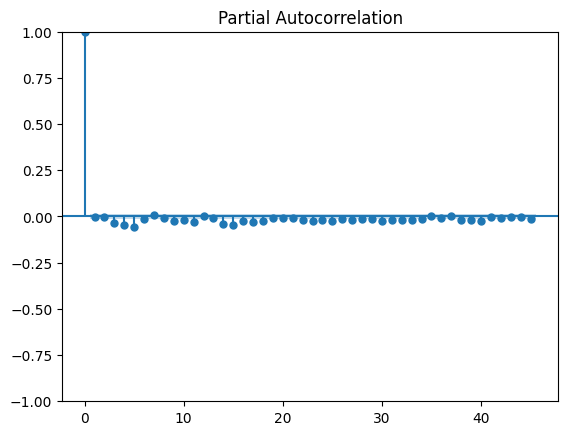

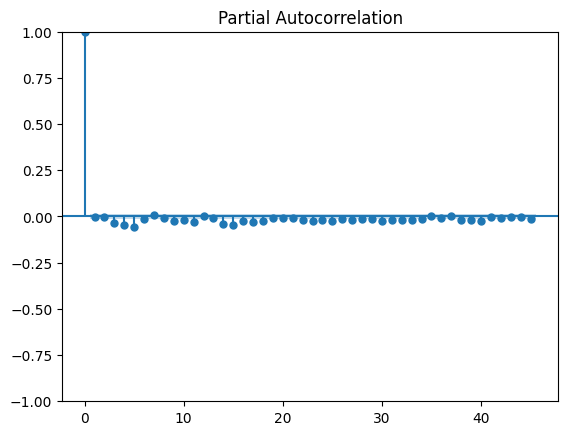

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(arima_model.predict_residuals()[1:])

In [5]:
def l2_improved(y_true, y_pred, indexes):
    if len(y_pred) != len(y_true):
        print("Lenghts are not the same!")
        return 0
    hour_vars = {0:     0.831691, 
                 3:     1.450059,
                 6:	    1.757970,
                 9:	    0.475864,
                 12:    0.629008,
                 15:	0.960935,
                 18:	1.110826,
                 21:	0.783646}
    s = 0
    n = len(y_true)
    for i in range(n):
        s += (y_true[i] - y_pred[i]) ** 2 * hour_vars[indexes[i]]
    return np.sqrt(s / n) 

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='T'>)

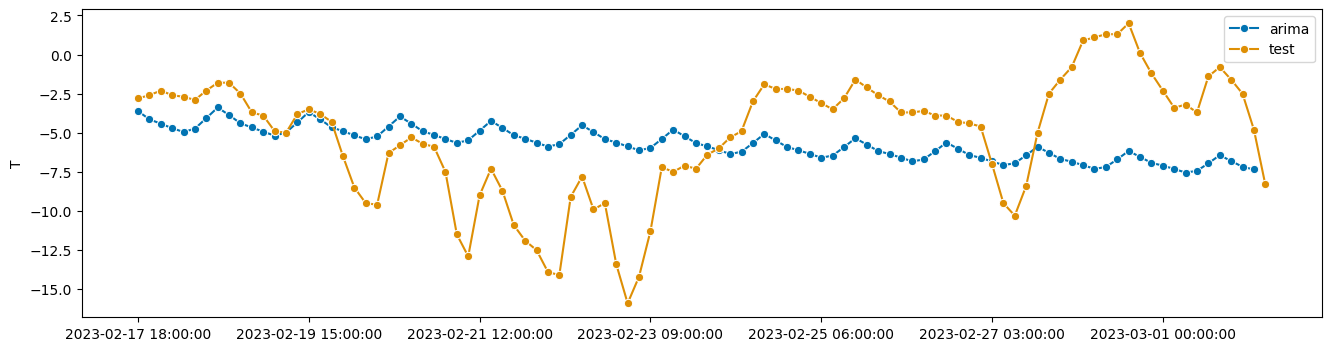

In [10]:
from sktime.utils.plotting import plot_series

plot_series(arima_model.predict(range(1,100)), temp_test[:100], labels=['arima', 'test'])

In [11]:
temp_test.shape

(2922,)

In [1]:
results = np.array([arima_model.predict(range(1,25))])

for i in range(200):
    print(round(i / 200, 4))
    arima_model.update(temp_test[9*i:9*(i+1)], update_params=False)
    results = np.append(results, [arima_model.predict(range(1,25))], axis=0)

NameError: name 'np' is not defined

In [ ]:
np.save("arima2res", results)

In [6]:
results = np.load("arima2res.npy")

1.0020775373414879

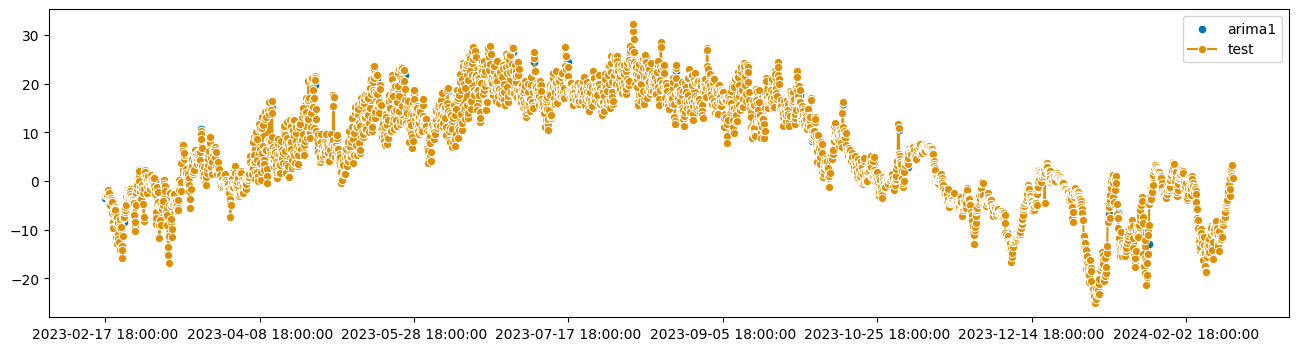

In [ ]:
results_3h = pd.Series(results[:,0])
results_3h.index = temp_test[[8*i for i in range(359)]].index

from sktime.utils.plotting import plot_series

plot_series(results_3h, temp_test, labels = ['arima1', 'test'])

In [7]:
maes = [l2_improved(results[:,j], temp_test[[9*i + j for i in range(201)]], temp_test.index[[9*i + j for i in range(201)]].hour) for j in range(24)]

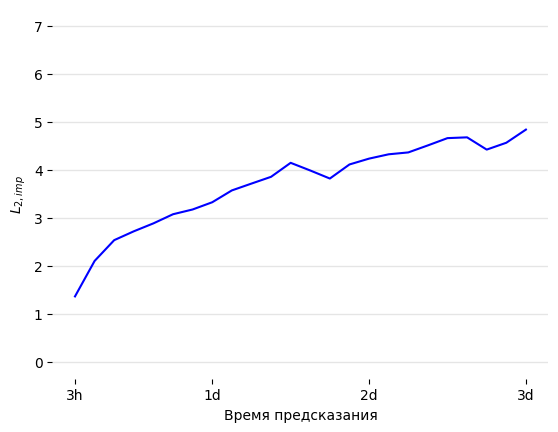

In [9]:
import matplotlib.pyplot as plt

x_values = list(range(24))
names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']

plt.box(False)
for h in range(8):
    plt.axhline(y=h, color='black', alpha=0.1, lw=1)

plt.plot(x_values, maes, color='blue')
plt.xticks(x_values, names)
plt.xticks([0,7,15,23])
plt.xlabel("Время предсказания")
plt.ylabel("$L_{2,imp}$")
plt.show()

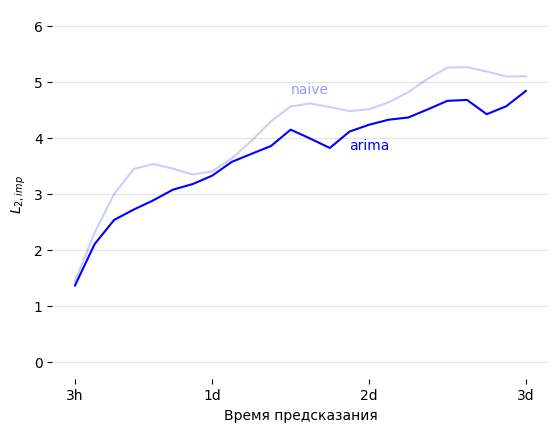

In [8]:
day_diff = [np.mean([temp_train[8 * i + j + 1] - temp_train[8 * i + j] for i in range(1, 6560)]) for j in range(8)]
maes_s = []
temp_test_predict = temp_test.values.copy()
for i in range(24):
    for j in range(len(temp_test_predict)):
        temp_test_predict[j] += day_diff[(j + i+ 6) % 8]
    maes_s.append(l2_improved(temp_test_predict[:-(i + 1)], temp_test[(i + 1):].values, temp_test.index[(i + 1):].hour))

import matplotlib.pyplot as plt

x_values = list(range(24))
names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']

plt.box(False)
for h in range(7):
    plt.axhline(y=h, color='black', alpha=0.1, lw=1)

plt.plot(x_values, maes_s, color='blue', alpha=0.2)
plt.plot(x_values, maes, color='blue')
plt.xticks(x_values, names)
plt.text(14, 3.8, "arima", color='blue')
plt.text(11, 4.8, "naive", color='blue', alpha=0.4)
plt.xticks([0,7,15,23])
plt.xlabel("Время предсказания")
plt.ylabel("$L_{2,imp}$")
plt.show()

In [10]:
for mae in maes:
    print(f"{mae}, ",end="")

1.3648835928739165, 2.1035506856498496, 2.537050965478064, 2.7212447140235474, 2.8866002234543053, 3.076821962631482, 3.1759682281117727, 3.3263500752832975, 3.572915794746735, 3.7152302234394994, 3.856319719449047, 4.14786543760261, 3.98814916662553, 3.8205142676643224, 4.113673670867024, 4.235502299123145, 4.325594985614661, 4.364605765604793, 4.5109944300821185, 4.662437254969248, 4.6786682879444115, 4.423366145483313, 4.565969660006295, 4.839871317764217, 